In [1]:
import tensorflow


In [2]:

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'D:\\flowers\\training_set'
valid_path = 'D:\\flowers\\test_set'

In [4]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [5]:
  # useful for getting number of classes
folders = glob('D:\\flowers\\training_set\\*')
folders

['D:\\flowers\\training_set\\daisy',
 'D:\\flowers\\training_set\\dandelion',
 'D:\\flowers\\training_set\\rose',
 'D:\\flowers\\training_set\\sunflower',
 'D:\\flowers\\training_set\\tulip']

In [6]:

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [14]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [15]:
# tell the model what cost and optimization method to use

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)


In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('D:\\flowers\\training_set',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('D:\\flowers\\test_set',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 4020 images belonging to 5 classes.
Found 706 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

hist = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
    callbacks=[monitor]
)

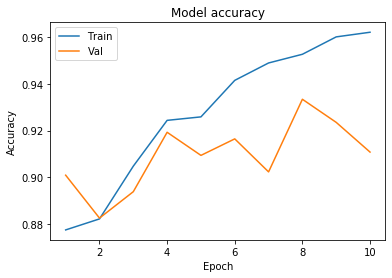

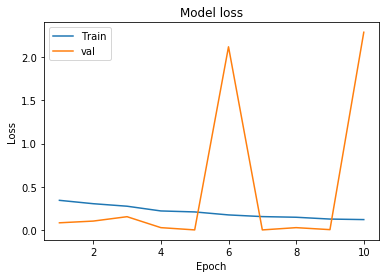

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
epoch=10
epoch_list=list(range(1,epoch+1))
# Plot training & validation accuracy values
plt.plot(epoch_list,hist.history['acc'])
plt.plot(epoch_list,hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epoch_list,hist.history['loss'])
plt.plot(epoch_list,hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

In [21]:
# serialize model to JSON
model_json = model.to_json()
with open("D:\\flowers\\vggmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("D:\\flowers\\vggmodel.h5")
print("Saved model to disk")

Saved model to disk


In [5]:

from keras.models import model_from_json
# load json and create model
json_file = open("D:\\flowers\\vggmodel.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("D:\\flowers\\vggmodel.h5")
print("Loaded model from disk")


Loaded model from disk


In [6]:
# tell the model what cost and optimization method to use
loaded_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)


In [7]:
score = loaded_model.evaluate(test_set, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


acc: 90.93%


{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


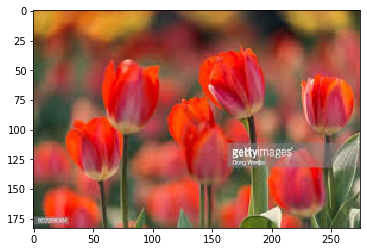

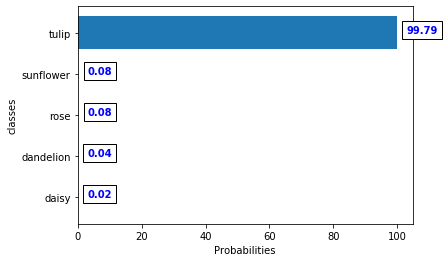

In [6]:
print(training_set.class_indices)
d=training_set.class_indices
classes=list(d)
classes
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.preprocessing import image
path='D:\\flowers\\single_prediction\\tulip.jpg'
test_image=image.load_img(path,target_size=(224,224))
test_image=image.img_to_array(test_image)
#plotting the image
import matplotlib.image as mpimg
image = mpimg.imread(path)
plt.imshow(image)
plt.show()
test_image=test_image.astype('float32')/255
test_image=np.expand_dims(test_image,axis=0)#converting to convo format
result=loaded_model.predict(test_image)
#print(classes)
result=np.ravel(result)
result=list(result)
result=["{0:.2f}".format(round(x*100,2)) for x in result]
result=[float(x) for x in result]
fig,ax=plt.subplots()
plt.barh(classes,result)
plt.xlabel('Probabilities')
plt.ylabel('classes')

for i, v in enumerate(result):
    ax.text(v + 3, i , str(v), color='blue', fontweight='bold',bbox=dict(facecolor='white', alpha=1))

In [11]:
fig.savefig('flower_tl_cnn_sample.png')